In [ ]:

import pandas as pd
import numpy as np
np.random.seed(42)

provinces = [
    "Aceh","Bali","Banten","Bengkulu","DI Yogyakarta","DKI Jakarta","Gorontalo","Jambi",
    "Jawa Barat","Jawa Tengah","Jawa Timur","Kalimantan Barat","Kalimantan Selatan",
    "Kalimantan Tengah","Kalimantan Timur","Kalimantan Utara","Kepulauan Bangka Belitung",
    "Kepulauan Riau","Lampung","Maluku","Maluku Utara","Nusa Tenggara Barat","Nusa Tenggara Timur",
    "Papua","Papua Barat","Riau","Sulawesi Barat","Sulawesi Selatan","Sulawesi Tengah",
    "Sulawesi Tenggara","Sulawesi Utara","Sumatera Barat","Sumatera Selatan","Sumatera Utara"
]

n = len(provinces)


poverty_pct = np.round(np.random.uniform(2.0, 25.0, size=n), 1)        # %
ipm = np.round(np.random.uniform(60.0, 80.0, size=n), 2)              # IPM
avg_school_years = np.round(np.random.uniform(6.0, 12.0, size=n), 1)  # tahun
life_expectancy = np.round(np.random.uniform(62.0, 74.5, size=n), 1)  # tahun
pdrb_per_capita_million = np.round(np.random.uniform(10.0, 150.0, size=n), 2)  # juta IDR
salary_mean_thousand = (np.round(np.random.uniform(1.0, 10.0, size=n), 2) * 1000).astype(int)

# Approximate lat/lon (centroid-like) — untuk plotting peta / PCA + map examples
latitudes = [5.55, -8.65, -6.12, -3.80, -7.80, -6.20, -0.55, -1.61,
             -6.90, -7.00, -7.25, -0.03, -3.33, -2.22, 0.50, 3.40,
             -2.10, 0.95, -5.45, -3.34, 1.50, -8.65, -9.75, -4.27,
             -2.85, 0.51, -2.98, -5.15, -3.69, 1.47, -0.95, -3.00, 2.97, -6.00]
longitudes = [95.32, 115.21, 106.12, 102.26, 110.37, 106.82, 123.06, 103.60,
              107.62, 110.42, 112.75, 109.35, 114.59, 114.03, 117.11, 116.86,
              106.13, 104.06, 105.26, 128.18, 127.50, 116.08, 122.22, 138.08,
              131.25, 101.45, 119.62, 119.43, 122.56, 124.84, 100.36, 104.75, 98.67, 106.12]

year = [2023]*n

df_prov = pd.DataFrame({
    "Provinsi": provinces,
    "Year": year,
    "Persentase_Penduduk_Miskin": poverty_pct,
    "IPM": ipm,
    "Rata_Rata_Lama_Sekolah": avg_school_years,
    "Umur_Harapan_Hidup": life_expectancy,
    "PDRB_perkapita_jutaIDR": pdrb_per_capita_million,
    "Mean_Salary_IDR": salary_mean_thousand,
    "lat": latitudes,
    "lon": longitudes
})


out_path = "/content/provinsi_data_praktikum.csv"
df_prov.to_csv(out_path, index=False)
print("File tersimpan di:", out_path)
print("Preview:")
print(df_prov.head(12).to_string(index=False))


File tersimpan di: /content/provinsi_data_praktikum.csv
Preview:
        Provinsi  Year  Persentase_Penduduk_Miskin   IPM  Rata_Rata_Lama_Sekolah  Umur_Harapan_Hidup  PDRB_perkapita_jutaIDR  Mean_Salary_IDR   lat    lon
            Aceh  2023                        10.6 79.31                     6.4                65.9                   82.63             7100  5.55  95.32
            Bali  2023                        23.9 76.17                    11.9                68.4                  108.42             1150 -8.65 115.21
          Banten  2023                        18.8 66.09                    10.6                73.3                   60.91             5610 -6.12 106.12
        Bengkulu  2023                        15.8 61.95                     7.2                65.1                  146.05             3040 -3.80 102.26
   DI Yogyakarta  2023                         5.6 73.68                     6.0                67.1                  144.74             6810 -7.80 110.37
     

In [ ]:
!pip install scikit-learn matplotlib joblib caas_jupyter_tools --quiet


ERROR: Could not find a version that satisfies the requirement caas_jupyter_tools (from versions: none)
ERROR: No matching distribution found for caas_jupyter_tools


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import joblib


try:
    import caas_jupyter_tools as cjt
    has_cjt = True
except:
    has_cjt = False

In [ ]:
DATA_PATH = "/content/provinsi_data_praktikum.csv"
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"{DATA_PATH} not found — upload your provinsi_data_praktikum.csv to Colab /content or change DATA_PATH")

df = pd.read_csv(DATA_PATH)

print("Dataset shape:", df.shape)
display(df.head(8))

Dataset shape: (34, 10)


,Provinsi,Year,Persentase_Penduduk_Miskin,IPM,Rata_Rata_Lama_Sekolah,Umur_Harapan_Hidup,PDRB_perkapita_jutaIDR,Mean_Salary_IDR,lat,lon
0,Aceh,2023,10.6,79.31,6.4,65.9,82.63,7100,5.55,95.32
1,Bali,2023,23.9,76.17,11.9,68.4,108.42,1150,-8.65,115.21
2,Banten,2023,18.8,66.09,10.6,73.3,60.91,5610,-6.12,106.12
3,Bengkulu,2023,15.8,61.95,7.2,65.1,146.05,3040,-3.80,102.26
4,DI Yogyakarta,2023,5.6,73.68,6.0,67.1,144.74,6810,-7.80,110.37
5,DKI Jakarta,2023,5.6,68.80,10.9,71.4,45.25,2570,-6.20,106.82
6,Gorontalo,2023,3.3,62.44,10.2,64.9,79.61,7220,-0.55,123.06
7,Jambi,2023,21.9,69.90,10.4,63.0,52.12,4480,-1.61,103.60


In [ ]:
print("\nMissing values per column:\n", df.isnull().sum())
print("\nDuplicate rows:", df.duplicated().sum())


Missing values per column:
 Provinsi                      0
Year                          0
Persentase_Penduduk_Miskin    0
IPM                           0
Rata_Rata_Lama_Sekolah        0
Umur_Harapan_Hidup            0
PDRB_perkapita_jutaIDR        0
Mean_Salary_IDR               0
lat                           0
lon                           0
dtype: int64

Duplicate rows: 0


In [ ]:
display(df.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Provinsi,34,34,Aceh,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,34.0,NaN,NaN,NaN,2023.0,0.0,2023.0,2023.0,2023.0,2023.0,2023.0
Persentase_Penduduk_Miskin,34.0,NaN,NaN,NaN,12.111765,6.71307,2.5,6.2,11.25,16.075,24.3
IPM,34.0,NaN,NaN,NaN,69.830294,6.121203,60.69,65.2425,69.35,75.905,79.39
Rata_Rata_Lama_Sekolah,34.0,NaN,NaN,NaN,8.826471,1.816975,6.0,6.825,9.05,10.4,11.9
Umur_Harapan_Hidup,34.0,NaN,NaN,NaN,68.211765,3.768672,62.1,64.95,67.25,72.1,73.8
PDRB_perkapita_jutaIDR,34.0,NaN,NaN,NaN,75.788235,39.71803,15.16,44.23,79.065,102.7475,147.99
Mean_Salary_IDR,34.0,NaN,NaN,NaN,5767.647059,2719.626822,1150.0,3215.0,6350.0,8267.5,9430.0
lat,34.0,NaN,NaN,NaN,-3.023235,3.80096,-9.75,-6.09,-3.165,-0.16,5.55
lon,34.0,NaN,NaN,NaN,113.001471,10.171452,95.32,105.475,111.585,119.5725,138.08


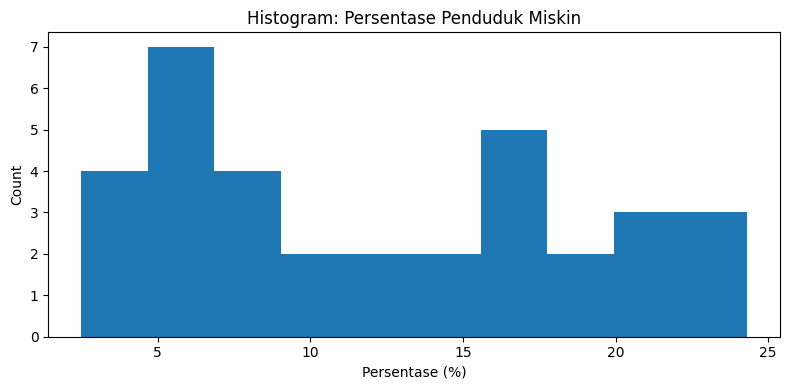

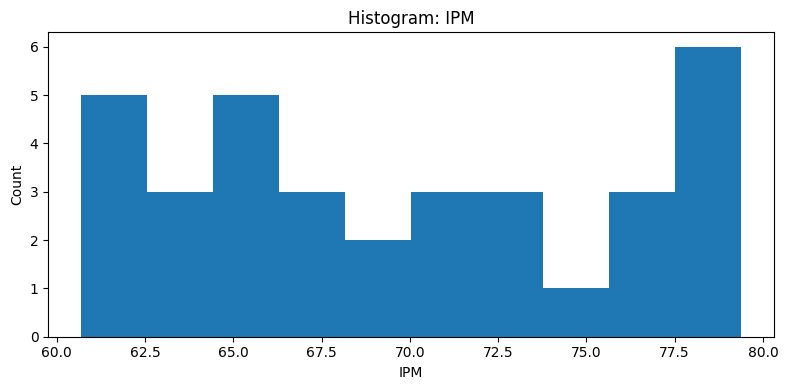

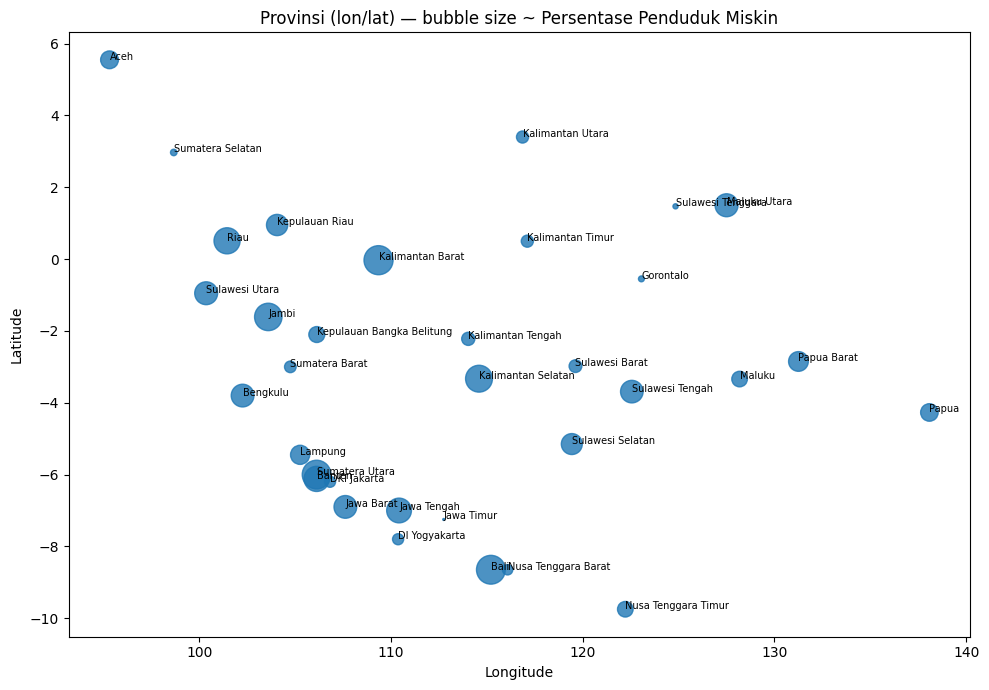

In [ ]:
plt.figure(figsize=(8,4))
plt.hist(df["Persentase_Penduduk_Miskin"], bins=10)
plt.title("Histogram: Persentase Penduduk Miskin")
plt.xlabel("Persentase (%)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.hist(df["IPM"], bins=10)
plt.title("Histogram: IPM")
plt.xlabel("IPM")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Simple scatter (lon/lat) — annotate with province short names
plt.figure(figsize=(10,7))
sizes = (df["Persentase_Penduduk_Miskin"] - df["Persentase_Penduduk_Miskin"].min()+0.1) * 20
plt.scatter(df["lon"], df["lat"], s=sizes, alpha=0.8)
for i, prov in enumerate(df["Provinsi"]):
    plt.text(df.loc[i,"lon"], df.loc[i,"lat"], prov, fontsize=7)
plt.title("Provinsi (lon/lat) — bubble size ~ Persentase Penduduk Miskin")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

In [ ]:
features = ["Persentase_Penduduk_Miskin","IPM","Rata_Rata_Lama_Sekolah","Umur_Harapan_Hidup","PDRB_perkapita_jutaIDR","Mean_Salary_IDR"]
X = df[features].copy()


In [ ]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

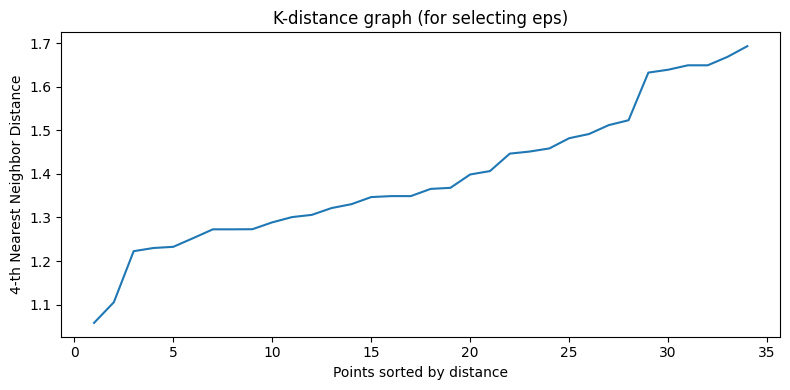

Elbow index: 2, eps_suggested: 1.2227, 90p: 1.6460, eps_chosen: 1.3168


/tmp/ipython-input-3119824122.py:20: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return abs(np.cross(b-a, a-pt)) / np.linalg.norm(b-a)


In [ ]:
k = 4
nbrs = NearestNeighbors(n_neighbors=k+1).fit(X_scaled)  # include self
distances, indices = nbrs.kneighbors(X_scaled)
k_distances = np.sort(distances[:, k])  # distance to k-th neighbor sorted

plt.figure(figsize=(8,4))
plt.plot(np.arange(1, len(k_distances)+1), k_distances)
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{k}-th Nearest Neighbor Distance")
plt.title("K-distance graph (for selecting eps)")
plt.tight_layout()
plt.show()

# 8b) Automatic elbow detection (distance to line method)
x = np.arange(len(k_distances))
y = k_distances
p1 = np.array([x[0], y[0]])
p2 = np.array([x[-1], y[-1]])
def point_line_distance(pt, a, b):
    return abs(np.cross(b-a, a-pt)) / np.linalg.norm(b-a)
dist_to_line = np.array([point_line_distance(np.array([x[i], y[i]]), p1, p2) for i in range(len(x))])
elbow_idx = dist_to_line.argmax()
eps_suggested = float(y[elbow_idx])
eps_percentile90 = float(np.percentile(y, 90))
eps_chosen = max(eps_suggested, 0.8 * eps_percentile90)
print(f"Elbow index: {elbow_idx}, eps_suggested: {eps_suggested:.4f}, 90p: {eps_percentile90:.4f}, eps_chosen: {eps_chosen:.4f}")

In [ ]:
eps = eps_chosen
min_samples = 5
db = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean', n_jobs=-1)
labels = db.fit_predict(X_scaled)
df['cluster'] = labels

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = int((labels == -1).sum())
print("Clusters found (excluding noise):", n_clusters)
print("Noise points:", n_noise)


Clusters found (excluding noise): 1
Noise points: 10


In [ ]:
if n_clusters > 1:
    sil_score = silhouette_score(X_scaled[labels!=-1], labels[labels!=-1])
    print("Silhouette score (excl. noise):", round(sil_score,4))
else:
    sil_score = None
    print("Silhouette score: not computed (less than 2 clusters)")

Silhouette score: not computed (less than 2 clusters)


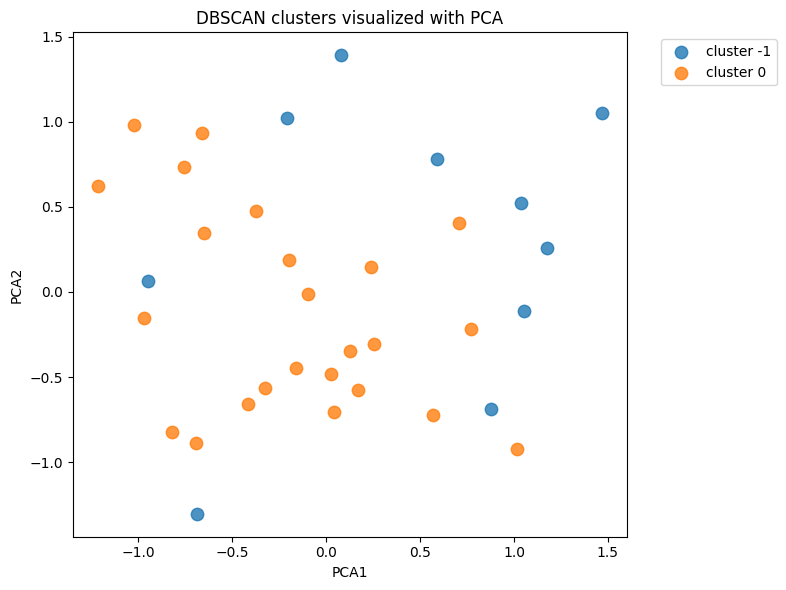

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df['pca1'] = X_pca[:,0]
df['pca2'] = X_pca[:,1]

plt.figure(figsize=(8,6))
unique_labels = sorted(df['cluster'].unique())
cmap = plt.get_cmap("tab10")
for idx, lab in enumerate(unique_labels):
    mask = df['cluster'] == lab
    plt.scatter(df.loc[mask,'pca1'], df.loc[mask,'pca2'], s=80, alpha=0.8, label=f"cluster {lab}", marker='o')
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("DBSCAN clusters visualized with PCA")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
cluster_summary = df.groupby('cluster')[features].agg(['count','mean','std']).round(3)
display(cluster_summary)


Persentase_Penduduk_Miskin                  IPM                 \
                             count    mean    std count    mean    std   
cluster                                                                  
-1                              10  16.200  8.077    10  71.425  6.259   
 0                              24  10.408  5.370    24  69.166  6.072   

        Rata_Rata_Lama_Sekolah               Umur_Harapan_Hidup          \
                         count   mean    std              count    mean   
cluster                                                                   
-1                          10  8.850  2.155                 10  68.410   
 0                          24  8.817  1.708                 24  68.129   

               PDRB_perkapita_jutaIDR                 Mean_Salary_IDR  \
           std                  count    mean     std           count   
cluster                                                                 
-1       4.143                     10  85.800  46.607              10   
 0       3.693                     24  71.617  36.765              24   

                             
             mean       std  
cluster                      
-1       3615.000  2378.708  
 0       6664.583  2354.544

In [ ]:
 out_csv = "/content/provinsi_dbscan_results.csv"
model_path = "/content/provinsi_dbscan_model.joblib"
df.to_csv(out_csv, index=False)
joblib.dump({"db": db, "scaler": scaler, "pca": pca, "features": features}, model_path)
print("Saved results to:", out_csv)
print("Saved model to:", model_path)


Saved results to: /content/provinsi_dbscan_results.csv
Saved model to: /content/provinsi_dbscan_model.joblib


In [ ]:
from google.colab import files
print("To download results interactively, run:")
print("files.download('/content/provinsi_dbscan_results.csv')")
print("files.download('/content/provinsi_dbscan_model.joblib')")

To download results interactively, run:
files.download('/content/provinsi_dbscan_results.csv')
files.download('/content/provinsi_dbscan_model.joblib')


In [ ]:
!pip install folium --quiet

import folium
from folium import plugins

# Menentukan warna untuk cluster
def cluster_color(c):
    if c == -1: return "black"     # noise
    colors = ["red", "blue", "green", "purple", "orange", "pink", "darkred", "cadetblue"]
    return colors[c % len(colors)]

# Membuat peta dasar (center Indonesia)
m = folium.Map(location=[-2.5, 118], zoom_start=5, tiles="cartodbpositron")

for i, row in df.iterrows():
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=6,
        color=cluster_color(row["cluster"]),
        fill=True,
        fill_color=cluster_color(row["cluster"]),
        fill_opacity=0.8,
        popup=f"""
        <b>{row['Provinsi']}</b><br>
        Cluster: {row['cluster']}<br>
        Miskin: {row['Persentase_Penduduk_Miskin']}%<br>
        IPM: {row['IPM']}
        """
    ).add_to(m)

m
